In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time

%matplotlib inline

In [83]:
base_path = './dataset-landmark'

train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')
validation_path = os.path.join(base_path, 'valid')

Classes: ['forest', 'buildings', 'glacier', 'street', 'mountain', 'sea']
Number of classes: 6
Found 11224 images belonging to 6 classes.
Found 2810 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


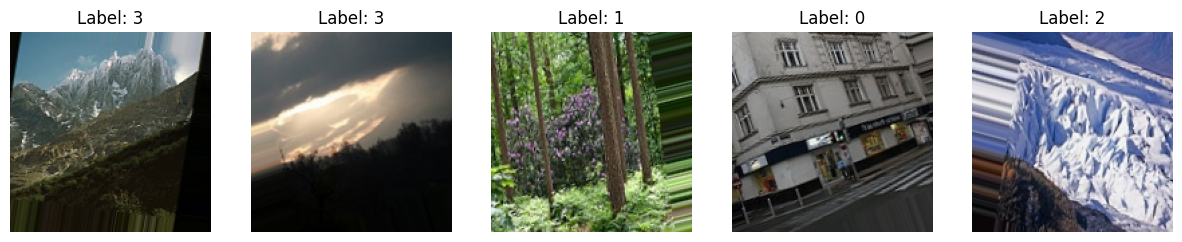

In [90]:
image_size = (150, 150)
batch_size = 64
channels = 3

# Get classes
classes = os.listdir(train_path)
print(f'Classes: {classes}')
num_classes = len(classes)
print(f'Number of classes: {num_classes}')

# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

validation_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
)
test_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
)

train_dataset = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
)

validation_dataset = validation_datagen.flow_from_directory(
    validation_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_dataset = test_datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Visualize processed images
def visualize_images(dataset, num_images=5):
    plt.figure(figsize=(15, 5))
    images, labels = next(dataset)

    images = np.clip(images, 0, 1)
    for i in range(min(num_images, len(images))):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.title(f'Label: {np.argmax(labels[i])}')
        plt.axis('off')
    plt.show()

visualize_images(train_dataset)

In [ ]:
def build_cnn_3conv(input_shape=(128,128,3), num_classes=6):
    model = Sequential()

    # # Conv block 1: 16 filtros
    model.add(Conv2D(16, (3,3), activation='relu', padding='same',
                            input_shape=input_shape))
    model.add(MaxPooling2D((2,2)))  # reduce a 40×40

    # Conv block 2: 32 filtros
    model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2)))  # reduce a 20×20

    # Conv block 3: 64 filtros
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2)))  # reduce a 10×10

    # Conv block 3: 64 filtros
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2)))  # reduce a 10×10
    
    # Conv block 3: 128 filtros
    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2)))  # reduce a 10×10

    # Añadir Dropout para reducir overfitting
    model.add(Dropout(0.3))

    # Aplanar y capa de salida
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [96]:
model = build_cnn_3conv(input_shape=(150,150,3), num_classes=num_classes)
model.summary()

# Compilar el modelo
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/Users/danielhurtado/Library/CloudStorage/GoogleDrive-a01707774@tec.mx/My Drive/Tec/FJ25/IA/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)              │ (None, 150, 150, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 75, 75, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 75, 75, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 37, 37, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 18, 18, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 9, 9, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │        12,294 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 146,662 (572.90 KB)

 Trainable params: 146,662 (572.90 KB)

 Non-trainable params: 0 (0.00 B)

In [87]:
# Entrenar el modelo
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=validation_dataset, verbose=1)

/Users/danielhurtado/Library/CloudStorage/GoogleDrive-a01707774@tec.mx/My Drive/Tec/FJ25/IA/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 44s 249ms/step - accuracy: 0.3752 - loss: 1.5106 - val_accuracy: 0.5715 - val_loss: 1.0702
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 45s 257ms/step - accuracy: 0.5595 - loss: 1.1136 - val_accuracy: 0.6577 - val_loss: 0.9138
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 62s 349ms/step - accuracy: 0.6311 - loss: 0.9674 - val_accuracy: 0.7142 - val_loss: 0.7523
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 104s 589ms/step - accuracy: 0.6635 - loss: 0.8867 - val_accuracy: 0.7505 - val_loss: 0.7065
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 127s 718ms/step - accuracy: 0.6990 - loss: 0.8113 - val_accuracy: 0.7676 - val_loss: 0.6458
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 73s 414ms/step - accuracy: 0.7095 - loss: 0.7785 - val_accuracy: 0.8007 - val_loss: 0.5581
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 66s 376ms/step - accuracy: 0.7310 - loss: 0.7270 - val_accuracy: 0.7786 - val_loss: 0.5944
Epoch 8/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 99s 565ms/step - accuracy: 0.7524 - loss:

In [ ]:
# Evaluar el modelo
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test accuracy: {test_accuracy:.4f}')

47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.8926 - loss: 0.3219
Test accuracy: 0.8690


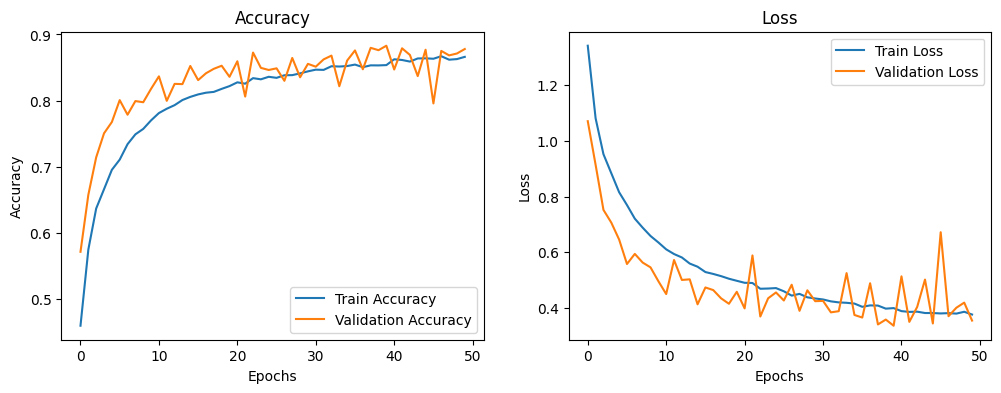

In [ ]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_history(history)

In [ ]:
def get_predictions(dataset, model):
    y_true = dataset.classes
    y_pred = model.predict(dataset, verbose=0)
    y_pred = np.argmax(y_pred, axis=1)
    return y_true, y_pred

y_true, y_pred = get_predictions(test_dataset, model)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

Classification Report:
              precision    recall  f1-score   support

      forest       0.79      0.92      0.85       437
   buildings       0.97      0.97      0.97       474
     glacier       0.87      0.76      0.81       553
      street       0.82      0.82      0.82       525
    mountain       0.88      0.90      0.89       510
         sea       0.90      0.88      0.89       501

    accuracy                           0.87      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.87      0.87      0.87      3000



<Figure size 1000x800 with 0 Axes>

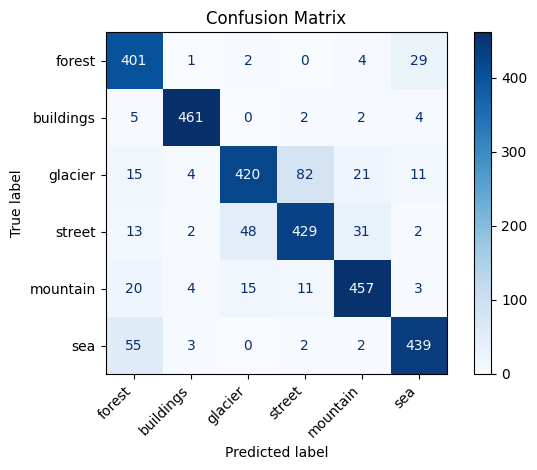

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)

    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    
    plt.figure(figsize=(10, 8))
    cm_display.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, classes)

In [89]:
model.save('intel_image_model.keras')